# **Primo minicontest**

#### Indice
* **Introduzione**
 * 1.1 Scelta della libreria
 * 1.2 Modello
* **Esecuzione**
 * 2.1 Caricamento librerie
 * 2.2 Caricamento del csv
 * 2.3 Estrazione degli attributi
 * 2.4 Studio degli attributi
 * 2.5 Manipolazione dei dati
* **Costruzione del modello**
 * 3.1 Introduzione
 * 3.2 Costruzione della rete
 * 3.3 Addestramento supervisionato
 * 3.4 Validazione
* **Predizione non supervisionata**
 * 4.1 Predizione
 * 4.2 Salvataggio


## 1. Introduzione
L'obiettivo di questo minicontest è quello di addestrare un modello al fine di determinare se una determinata zona del territorio è impermeabile, *impervious*, oppure no; risulta quindi chiaro che stiamo trattando un problema di classificazione binaria.

I dati in nostro possesso sono stati ottenuti dalla sonda Sentinel-2 dell'ESA attraverso i suoi sensori, sensibili a differenti lunghezze d'onda; abbiamo quindi collezionato misure in 13 differenti bande dello spettro.

Il training set contiene le misure ottenute dalla sonda per due differenti *tile* del territorio italiano (con la corretta classe di predizione per ogni pixel identificato nel tile stesso), mentre il test set contiene le misure ottenute su un tile completamente slegato dai primi due e senza la corretta classe di predizione associata ad ogni pixel.

### 1.1 Scelta della libreria
Prima di adottare Keras abbiamo provato altri strumenti; nell'ordine:
- Knime
- Matlab
- Scikit Learner

Per la scelta del modello, però (una rete neurale) si è preferito lavorare con Keras, una libreria che fa da wrapper a TensorFlow (la libreria per il Deep Learning sviluppata da Google) e rappresenta quindi lo stato dell'arte del deep learning odierno, nonché [una delle più utilizzate a livello mondiale][1].

[1]: https://towardsdatascience.com/deep-learning-framework-power-scores-2018-23607ddf297a

### 1.2 Modello

Come primi modelli sono stati usati i seguenti classificatori:
- **Decision Tree** (criterio di split = indice di diversità di Gini)
- **K Nearest Neighbor** (k = 11, distanze pesate)

Il modello adottato successivamente è stato **MLP** (Multi Layer Perceptron) realizzato inizialmente con Scikit Learn e successivamente con Keras; il cambio è dovuto ad un maggior numero di iperparametri configurabile.

Il modello risultato vincitore è una rete neurale composta da tre hidden layers, un input layer ed un output layer.
- L'input layer ha tanti ingressi quante sono le feature (13 nel nostro caso) ed un numero di uscite arbitrario (abbiamo posto 32);
- I tre hidden layer sono uguali in quanto a funzione di attivazione; per tutti e tre essa è la [ReLU][2], cioé la funzione definita come $f(x) = \textrm{max}\{0, x\}$; questa funzione è molto utilizzata in letteratura - soprattutto per le deep networks - per la velocità maggiore di apprendimento rispetto alla tangente iperbolica o alla sigmoide;
 - L'hidden layer 1 ha un input di 13 nodi ed un output di 32 nodi;
 - L'hidden layer 2 ha un input di 32 nodi ed un output di 64 nodi;
 - L'hidden layer 3 ha un input di 64 nodi ed un output di 32 nodi;
- L'ultimo layer, l'output layer, ha 32 ingressi ed una sola uscita con funzione di attivazione sigmoide; la funzione è non lineare e soprattutto è molto efficace per classificazioni binarie (insieme all'avere un unico neurone in output).
[2]: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

## 2. Studio dei dati

### 2.1 Caricamento librerie
Per prima cosa carichiamo tutte le librerie di cui avremo bisogno nel corso del notebook.

In [82]:
import tensorflow as tf
def upgrade_tf():
    if tf.__version__.split('.')[0] == '1':
        !pip uninstall tensorflow
        !pip install tensorflow
        !pip uninstall keras
        !pip install keras
upgrade_tf()
tf.__version__

'2.0.0'

In [0]:
# core packages
import numpy as np
import pandas as pd
import keras
import os
from os.path import join as joinpath
import time

# plot packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

# folder di supporto all'esecuzione
in_folder  = 'input'
out_folder = 'output'
model_folder = 'model'
res_folder = 'result'

### 2.2 Caricamento del csv

Carichiamo in memoria il dataset in formato csv con la libreria `pandas`.

In [0]:
# ottieni il trainset caricato su kaggle in formato pd.DataFrame
train_set = pd.read_csv(joinpath(in_folder, 'training.csv'))

### 2.3 Estrazione degli attributi

Una volta ottenuta la tabella di *training.csv*, la modifichiamo in modo da ottenere nei dataset delle x solamente le feature del problema (le 13 bande spettrali acquisite da Sentinel-2), mentre nel trainset della y avremo le label corrette.

In [0]:
# il drop non avviene in place
x_trainset = train_set.drop(labels=['name', 'x', 'y', 'Imperviousness'], axis=1)
y_trainset = train_set['Imperviousness']

# possiamo cancellare la tabella, non ci servirà più in memoria
del train_set

### 2.4 Studio degli attributi
Andiamo ora a studiare gli attributi per determinare se è necessario applicare una normalizzazione (ricordiamo che è necessario avere tutti i valori delle feature compresi in $[0,1]$ o $[-1,1]$ quando utilizziamo una rete neurale, poiché essa è *molto* sensibile ad eventuali outliers).

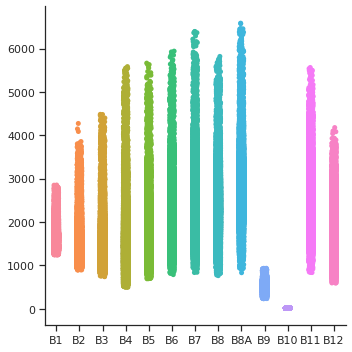

In [86]:
g = sns.catplot(data=x_trainset)

### 2.5 Manipolazione dei dati

Come abbiamo notato nella figura precedente, c'è il bisogno di applicare una manipolazione sui dati per renderli adatti al classificatore utilizzato.

#### 2.5.1 Holdout
Prima di manipolare i dati normalizzandoli, per rendere più robusto il procedimento possiamo procedere a fare un *holdout*, cioé a splittare l'intero dataset di training in due set di dimensione minore, *train set* e *test set*. 

Questo procedimento è necessario farlo prima dello scaling perché allo scaler "insegneremo" come trasformare i dati sul train set, mentre sul test set ottenuto dall'holdout applicheremo semplicemente la trasformazione.

Questo è lo stesso processo che faremo successivamente quando dovremo fare *prediction* sul test set non classificato; trasformeremo il test set con questo stesso `Scaler`.

Utilizzando una funzione fornita da Scikit Learn vado a dividere il dataset decidendo quanto dare al trainset e quanto al testset. Abbiamo scelto di dare l'80% del dataset al training set, ed il restante 20% al testset.

Fissando il seme è possibile rendere lo split deterministico, per non avere risultati che potrebbero cambiare ad ogni esecuzione.

In [0]:
from sklearn.model_selection import train_test_split

# uso un seed fisso per replicare gli esperimenti
seed = 10
np.random.seed(seed)

# splitto il dataset in train e test (per ambo x e y)
x_train, x_test, y_train, y_test = train_test_split(
    x_trainset, y_trainset, test_size=0.2, random_state=seed
)

# riottengo tabelle
x_train = pd.DataFrame(x_train, columns=x_trainset.columns)
x_test = pd.DataFrame(x_test, columns=x_trainset.columns)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

#### 2.5.2 Normalizzazione
Una volta ottenuti train set e test set tramite holdout, possiamo passare alla normalizzazione dei dati facendo *fitting* **solamente** sui dati del trainset (il test set, ricordiamo, è un'incognita che non deve in alcun modo influenzare train set ed apprendimento).

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fitting solamente su dati del training
scaler.fit(x_train.values)

# trasformazione di entrambi
x_train[:] = scaler.transform(x_train.values)
x_test[:] = scaler.transform(x_test.values)

#### 2.5.3 Visualizzazione
Plottiamo ora i dati trasformati, per vedere come ha agito lo scaler, sia sul train set che sul test set.

Il box rappresenta i due quartili centrali della distribuzione (25-50 e 50-75), mentre i *whisker*, i baffi, rappresentano il resto della distribuzione. I punti al di fuori del *box-and-whisker* sono considerati outlier.

Come si nota, la trasformazione è andata a buon fine, poiché la maggior parte dei valori si trova nell'intervallo $[-2,2]$, fatta eccezione per alcuni outlier che possono costituire rumore.

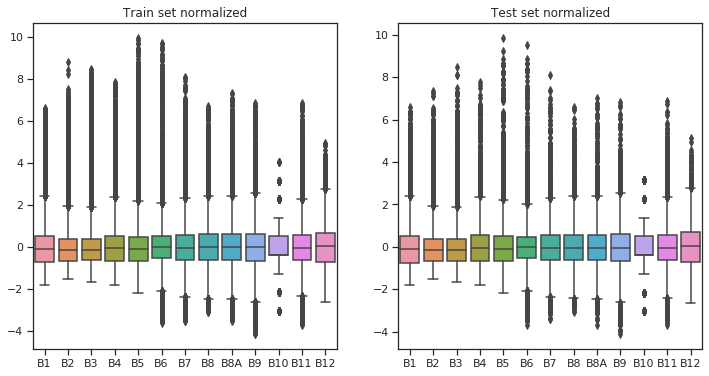

In [89]:
f, axes = plt.subplots(1, 2, figsize=(12, 6))
g = sns.boxplot(data=x_train, ax=axes[0]).set_title('Train set normalized')
g = sns.boxplot(data=x_test, ax=axes[1]).set_title('Test set normalized')

## 3. Costruzione del modello

### 3.1 Introduzione
Andremo ora a costruire il nostro modello di classificazione, nel nostro caso una rete neurale MLP.

A differenza degli altri strumenti presentati in precedenza, Keras è una libreria dedita solamente al Deep Learning; risulta quindi chiaro che le modifiche consentite sugli iperparametri sono molte e, di conseguenza, può risultare più ostico trovare un risultato migliore.

Bisogna inoltre ricordare che l'apprendimento di una rete neurale è fatto ad **epoche**, ovvero gli stessi dati vengono presentati più volte al modello affinché esso possa migliorare i parametri (i pesi sugli archi che connettono i vari neuroni o percettroni), cioé ridurre la loss (funzione di costo) ed aumentare la metrica selezionata (nel nostro caso l'accuracy).

### 3.2 Costruzione della rete

#### 3.2.1 Layers
Keras ci offre la possibilità di costruire una NN attraverso più tipi diversi di layer (il modello, `Sequential`, è unico, ma viene offerta la possibilità di specializzare un `Model` generico).

I layer che ci interessano per fare una MLP tradizionale sono `Dense` e `Dropout`.

- `Dense` rappresenta un normale layer con un output (quanti neuroni abbiamo in uscita) e con un input (opzionale se sono hidden/output layer, può essere *inferred*); viene inoltre offerta la possibilità di decidere quale funzione di attivazione utilizzare. Come abbiamo già affermato nel primo capitolo, gli hidden layer che costruiremo utilizzano una ReLU, mentre l'output una Sigmoide;
- `Dropout` rappresenta un metalayer, cioé ha bisogno di un layer su cui appoggiarsi poiché "spegne" dei neuroni  in maniera casuale per introdurre rumore e rendere così la NN più robusta (questa pratica evita l'overfitting). Abbiamo scelto per ogni hidden layer di spegnere il 25% dei neuroni.

Su 32 nodi di uscita, ne rimarranno 24 attivi, mentre su 64 nodi ne rimarranno attivi 48.

#### 3.2.2 Compilazione
Per quanto riguarda la compilazione, un modello di ANN fatto in Keras ha bisogno di tre parametri: `loss`, `metrics` e `optimizer`.

- `loss` indica la funzione di costo o di errore, ed è una funzione che va minimizzata. Per questo problema di classificazione binaria abbiamo scelto `binary_crossentropy`;
- `metrics` indica l'array delle funzioni da massimizzare. Abbiamo selezionato solamente `accuracy`;
- `optimizer` indica quale algoritmo utilizzare per far apprendere la rete. Abbiamo selezionato Adam, una variante della SGD, molto utilizzato in letteratura per la maggior velocità di convergenza rispetto a quest'ultimo.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

n_features = len(x_trainset.columns)

def create_model(optimizer):
    # creazione della rete
    model = Sequential()

    # input layer
    model.add(Dense(32, activation='relu', input_dim=n_features))
    model.add(Dropout(0.25))

    # hidden layer #1
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    
    # hidden layer #2
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    
    # hidden layer #3
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(
        loss='binary_crossentropy',
        metrics=['accuracy'],
        optimizer=optimizer)
    
    return model

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier

optimizer = 'adam'
# model = create_model(optimizer)
model = KerasClassifier(build_fn=create_model, optimizer=optimizer)

#### 3.2.3 Riepilogo del modello

In [0]:
if type(model) is Sequential:
    model.summary()

### 3.3 Addestramento supervisionato
Una volta creato il modello con l'optimizer desiderato, provvediamo ad addestrarlo. 

Anche qui abbiamo una vasta scelta di iperparametri, legati all'apprendimento di una rete neurale.

Innanzitutto possiamo settare il numero di epoche, ovvero il numero di volte che l'intero train set verrà dato in pasto alla rete per aggiornare i pesi degli archi dei neuroni; un valore troppo basso non farà convergere il modello verso l'accuracy massima, mentre un valore troppo alto sarà una spesa computazionale inutile, poiché l'accuracy oscillerà attorno ad un valore massimo.

Subito dopo possiamo settare il batch-size (chiamato anche *mini-batch-size* per distinguerlo dal trainset) per definire la granularità dell'input; più è grande, meno sarà accurato il modello, ed ovviamente più è piccolo e più sarà lento il modello a convergere (ed inoltre la rete potrebbe andare in overfitting).

Un altro parametro importante è il `validation_split`, ovvero quanta percentuale del trainset tenere da parte in ogni epoca e sulla quale fare predizione; ci serve per dare un'idea dell'andamento di accuracy e loss. Abbiamo scelto di prendere il 20% del trainset ed usarlo come validation set.
In aggiunta, abbiamo impostato lo shuffle dei dati ad ogni iterazione.



In [93]:
def fit(model):
    return model.fit(
        x_train, y_train, 
        epochs=50,
        workers=10,
        validation_split=0.2,
        shuffle=True,
        batch_size=32
    )

history = fit(model)

Train on 42809 samples, validate on 10703 samples
Epoch 1/50
42809/42809 [==============================] - 2s 56us/step - loss: 0.3754 - accuracy: 0.8410 - val_loss: 0.3143 - val_accuracy: 0.8693
Epoch 2/50
42809/42809 [==============================] - 2s 51us/step - loss: 0.3215 - accuracy: 0.8670 - val_loss: 0.2917 - val_accuracy: 0.8796
Epoch 3/50
42809/42809 [==============================] - 2s 52us/step - loss: 0.3023 - accuracy: 0.8745 - val_loss: 0.2757 - val_accuracy: 0.8857
Epoch 4/50
42809/42809 [==============================] - 2s 52us/step - loss: 0.2929 - accuracy: 0.8801 - val_loss: 0.2699 - val_accuracy: 0.8881
Epoch 5/50
42809/42809 [==============================] - 2s 52us/step - loss: 0.2847 - accuracy: 0.8848 - val_loss: 0.2621 - val_accuracy: 0.8932
Epoch 6/50
42809/42809 [==============================] - 2s 52us/step - loss: 0.2794 - accuracy: 0.8868 - val_loss: 0.2532 - val_accuracy: 0.8959
Epoch 7/50
42809/42809 [==============================] - 2s 51us/st

Possiamo ora plottare i risultati ottenuti dal nostro modello in fase di training in due plot differenti; nel primo mostriamo l'andamento dell'accuracy all'aumentare delle epoche, nel secondo l'andamento della curva di loss.

Notiamo che abbiamo ottimi risultati, poiché l'accuracy media sul validation set è superiore a quella del train (anche se di poco); stesso discorso vale per la loss.

Mean accuracy:     0.89552
Mean val accuracy: 0.90039

Mean loss:     0.26301
Mean val loss: 0.24523


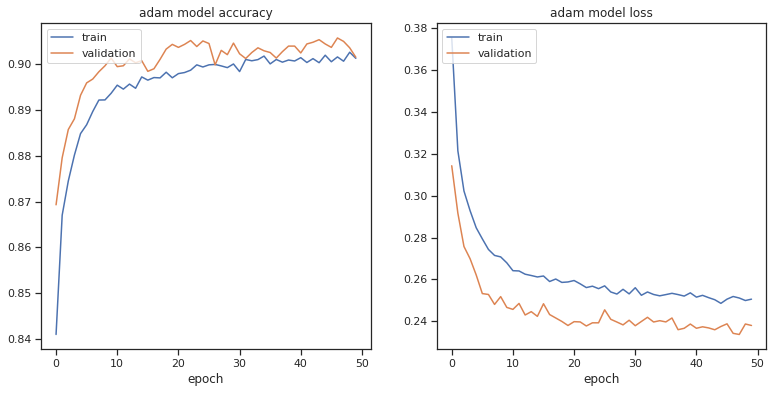

In [94]:
def do_plot(history, opt_name=''):
    hist = history.history
    # compatibilità con TF 1 e 2
    acc = hist.get('accuracy') or hist.get('acc')
    val_acc = hist.get('val_accuracy') or hist.get('val_acc')
    loss = hist.get('loss')
    val_loss = hist.get('val_loss')

    print('Mean accuracy:     {:.5f}'.format(np.mean(acc)))
    print('Mean val accuracy: {:.5f}'.format(np.mean(val_acc)))
    print()
    print('Mean loss:     {:.5f}'.format(np.mean(loss)))
    print('Mean val loss: {:.5f}'.format(np.mean(val_loss)))

    name = opt_name + ' ' if opt_name else ''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

    ax1.plot(acc)
    ax1.plot(val_acc)
    ax1.set_title('{}model accuracy'.format(name))
    ax1.set(xlabel='epoch')
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(loss)
    ax2.plot(val_loss)
    ax2.set_title('{}model loss'.format(name))
    ax2.set(xlabel='epoch')
    ax2.legend(['train', 'validation'], loc='upper left')

do_plot(history, optimizer)

### 3.4 Validazione
Una volta addestrata la rete, proviamola sul testset ottenuto prima in fase di holdout. 

Poiché questo dataset non è stato mai visto prima dalla rete (né ha influenzato in alcun modo il trainset), possiamo essere confidenti che il risultato di accuracy avrà un certo significato.

Bisogna tuttavia ricordare che il tile da classificare è completamente diverso, quindi la nostra rete dovrà essere in grado di generalizzare bene (mentre training e test sono fatti su due tile relativamente simili fra di loro).


In [95]:
def score_model(model, name):
    # fa la prediction di x_test e la confronta con y_test (la label vera)
    if type(model) is Sequential:
        score = model.evaluate(x_test, y_test, verbose=0)
        metrics = list(zip(model.metrics_names, score))
        y_pred = model.predict
    elif type(model) is KerasClassifier:
        score = model.score(x_test, y_test, verbose=0)
        metrics = ['accuracy', score]
    
    # stampa a video
    print(metrics)
    # e su file lo score ottenuto
    fname = 'mlp_{n}_{t}.txt'.format(n=name, t=str(int(time.time())))
    with open(joinpath(res_folder, fname), 'w') as f:
        f.write(str(metrics))

    if type(model) is Sequential:
        return model.predict_classes(x_test, verbose=0)
    elif type(model) is KerasClassifier:
        return model.predict(x_test, verbose=0)

y_pred = score_model(model, optimizer)

['accuracy', 0.9043952822685242]


Confrontando i risultati ottenuti con quelli precedenti, notiamo che sono in linea con quelli ottenuti in fase di training.



### 3.5 Metriche
Il risultato di accuracy ottenuto, per quanto sia positivo, non è propriamente indicativo della bontà del classificatore addestrato.

Per ovviare a questo problema, useremo grafici molto significativi per un classificatore binario: curva ROC e matrice di confusione.

#### 3.5.1 Curva ROC

La curva ROC è una curva plottata in uno spazio dimensionale $[0,1]\times[0,1]$ dove sull'asse delle ascisse poniamo il rate dei falsi positivi (istanze classificate come 1 quando in realtà erano 0), mentre sull'asse delle ordinate poniamo il rate dei veri positivi (istanze classificate correttamente come 1).

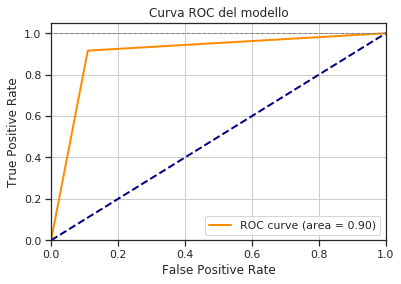

In [96]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot([1, 0], [1, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC del modello')
plt.legend(loc="lower right")
plt.show()

Possiamo notare come la curva sia molto spigolosa e sale velocemente verso 1, quindi è un ottimo risultato; inoltre anche l'area sotto la curva ROC ha un valore elevato, 0.90.

#### 3.5.2 Matrice di confusione

Una matrice di confusione è una matrice i cui elementi $c_{i,j}$ sono il numero di campioni che appartengono alla classe $i$ ma vengono classificati nella classe $j$.

Poiché ovviamente vogliamo massimizzare il rate di veri positivi e veri negativi, gli elementi sulla diagonale principale devono essere molto maggiori di quelli sulla diagonale secondaria.

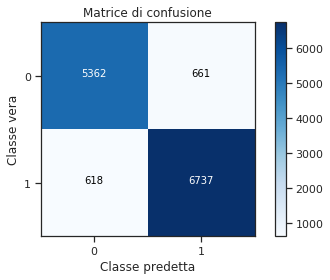

In [97]:
from sklearn.metrics import confusion_matrix
import itertools

cf = confusion_matrix(y_true=y_test, y_pred=y_pred)

axes = plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Matrice di confusione')
plt.xlabel('Classe predetta')
plt.ylabel('Classe vera')
tick_marks = np.arange(2)
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
plt.ylim([1.5, -.5])
# plotting text value inside cells
thresh = cf.max() / 2
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.tight_layout()
plt.show()

Come con la curva ROC, notiamo che il nostro classificatore si comporta molto bene anche sul test set, quindi siamo confidenti che possa avere un buon risultato anche su dati mai visti.

## 4. Predizione non supervisionata

### 4.1 Predizione
Andiamo ora a predire i dati sul testset fornitoci su Kaggle.

Poiché abbiamo già caricato il CSV, ci resta da filtrare i dati e normalizzarli con lo scaler creato ed addestrato in precedenza.

In [0]:
# carichiamo in memoria il testset di Kaggle da classificare
test_set  = pd.read_csv(joinpath(in_folder, 'test.csv'))

# prendiamo i dati dal test set non labellato
x_testset = test_set.drop(labels=['name', 'x', 'y', 'Imperviousness'], axis=1)

# e li trasformiamo con lo standard scaler ottenuto dal nostro training set
x_testset = scaler.transform(x_testset)

# ed infine prediciamo la classe (0 o 1) per ogni sample
if type(model) is Sequential:
    y_pred = model.predict_classes(x_testset, verbose=0)
elif type(model) is KerasClassifier:
    y_pred = model.predict(x_testset, verbose=0)

### 4.2 Salvataggio
Passiamo ora a salvare lo stato dell'elaborazione, sia per conservare la predizione ottenuta (che andrà poi inviata su Kaggle) sia per salvare il modello e caricarlo all'occorrenza (a causa degli elevati costi di training).

#### 4.2.1 Salvataggio del csv

In [0]:
# crea l'header del file csv
cols = ['ID', 'Imperviousness']
# crea la colonna degli ID (da 1 a n)
row_col = np.arange(1, len(y_pred) + 1).reshape(len(y_pred), 1)
# crea il dataframe e salvalo come csv
pd.DataFrame(
    data=np.concatenate([row_col, y_pred], axis=1),
    columns=cols
).to_csv(
    joinpath(out_folder, 'result_{name}_{t}.csv'.format(name=optimizer, t=str(int(time.time())))),
    columns=cols,
    index=False
)

#### 4.2.2 Salvataggio del modello

In [0]:
def save_model(model, name):
    tstamp = int(time.time())
    fname = '{n}_{t}.h5'.format(n=name, t=tstamp)
    model.save(joinpath(model_folder, fname))

if type(model) is Sequential:
    save_model(model, optimizer)

#### 4.2.3 Caricamento del modello

In [0]:
def load_model(name=None):
    from keras.models import load_model as ld
    
    h5files = []
    for f in os.scandir(model_folder):
        if not f.is_file():  # skip elements not file
            continue
        if f.name.lower().endswith('.h5'):
            h5files.append(f.name)
    
    if not h5files:
        raise ValueError("No h5 file found inside {}. Maybe you never saved a (trained) model?".format(model_folder))
    
    # ordina sul timestamp
    h5files.sort(key=lambda e: int(e.split('.')[0].split('_')[1]))
    
    # se è stato selezionato uno specifico optimizer, carica quello (l'ultimo)
    # altrimenti carica l'ultimo modello salvato
    if name:
        h5filt = [h5 for h5 in h5files if name in h5]
        to_load = h5filt[-1]
    else:
        to_load = h5files[-1]
    
    return ld(joinpath(model_folder, to_load))

if type(model) is Sequential:
    model_loaded = load_model()